In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib_venn import venn2

In [2]:
from protein_conformal.util import *

In [3]:
import faiss

In [4]:
scope = np.load('/data/ron/protein-conformal/data/SCOPe_multidomain_embeddings_protein_vec.npy')
print(scope.shape)

# load scope metadata
_, scope_metadata = read_fasta('/data/ron/protein-conformal/data/SCOPe_multidomain.fasta')
print(len(scope_metadata))

(74, 512)
74


In [5]:
afdb = np.load('/data/ron/protein-conformal/data/afdb_embeddings_protein_vec.npy')
# load afdb metadata
_, afdb_metadata = read_fasta('/data/ron/protein-conformal/data/AFDB_sequences.fasta')
print(len(afdb_metadata))
print(afdb.shape)

2302899
(2302899, 512)


In [ ]:
# remove > at the beginning of the string for scope metadata and afdb metadata
scope_metadata = [x[1:] for x in scope_metadata if x[0] == '>']
afdb_metadata = [x[1:] for x in afdb_metadata if x[0] == '>']

In [9]:
afdb_lookup = load_database(afdb)

In [82]:
# Query for the 1st nearest neighbor
k = 2302899
D, I = query(afdb_lookup, scope, k)

In [83]:
I.shape

(74, 2302899)

(array([1.000000e+00, 1.000000e+00, 0.000000e+00, 1.000000e+00,
        1.000000e+00, 4.000000e+00, 2.000000e+00, 7.000000e+00,
        1.200000e+01, 1.100000e+01, 2.300000e+01, 1.900000e+01,
        2.600000e+01, 3.400000e+01, 6.700000e+01, 1.010000e+02,
        1.160000e+02, 1.750000e+02, 2.250000e+02, 3.450000e+02,
        4.400000e+02, 6.210000e+02, 9.780000e+02, 1.228000e+03,
        1.795000e+03, 2.567000e+03, 3.542000e+03, 4.879000e+03,
        6.896000e+03, 9.305000e+03, 1.276300e+04, 1.703500e+04,
        2.260300e+04, 3.065800e+04, 4.043300e+04, 5.232700e+04,
        6.863200e+04, 8.943400e+04, 1.135810e+05, 1.453280e+05,
        1.835150e+05, 2.336850e+05, 2.897250e+05, 3.566140e+05,
        4.438800e+05, 5.403140e+05, 6.504580e+05, 7.874210e+05,
        9.461790e+05, 1.109799e+06, 1.316724e+06, 1.548919e+06,
        1.774403e+06, 2.072937e+06, 2.352513e+06, 2.716124e+06,
        3.066747e+06, 3.413185e+06, 3.864935e+06, 4.263345e+06,
        4.650218e+06, 5.126304e+06, 5.57

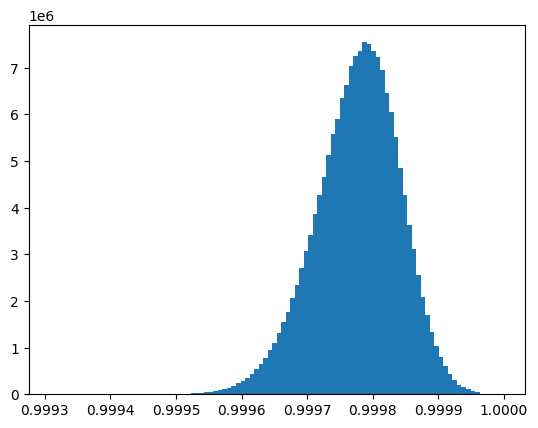

In [84]:
# plot histogram of distances
plt.hist(D.flatten(), bins=100)

In [ ]:
# load DALI results

In [32]:
dali_1oisA = pd.read_csv('/data/ron/protein-conformal/data/dali_multidomain_results_csv/1oisA.csv')

In [36]:
dali_1oisA.head()

,query,target,Z,RMSD,Alignment_Length,Hit_Length,Query_Length,Perc_Ident,Query_Cov_Perc,Full_Alignment,Alphafold_link
0,1ois,A0A7J2Z1R5,3.1,15.8,93,160,1000,9,9.3,NaN,https://alphafold.ebi.ac.uk/entry/A0A7J2Z1R5
1,1ois,A0A7H4LGP6,2.3,5.3,69,102,1000,12,6.9,NaN,https://alphafold.ebi.ac.uk/entry/A0A7H4LGP6
2,1ois,F0ZDL3,3.3,18.4,98,499,1000,7,9.8,NaN,https://alphafold.ebi.ac.uk/entry/F0ZDL3
3,1ois,V9IJC9,18.7,1.5,187,685,1000,41,18.7,NaN,https://alphafold.ebi.ac.uk/entry/V9IJC9
4,1ois,A0A0D3D5Z1,2.3,21.2,82,351,1000,5,8.2,NaN,https://alphafold.ebi.ac.uk/entry/A0A0D3D5Z1


In [37]:
len(dali_1oisA)

47

In [38]:
scope_metadata[0]

'>2hhvA'

In [41]:
'>1oisA' in scope_metadata
# get location of 1oisA in scope
scope_idx = [i for i, x in enumerate(scope_metadata) if '>1oisA' in x][0]

In [42]:
scope_idx

22

In [68]:
scope_metadata[0]

'2hhvA'

In [69]:
afdb_metadata[0]

'A0A009E921'

In [50]:
dali_1oisA['target'][0] in afdb_metadata

True

In [70]:
dali_test = pd.read_csv('/data/ron/protein-conformal/data/dali_multidomain_results_csv/2hhvA.csv')

In [71]:
dali_test.head()

,query,target,Z,RMSD,Alignment_Length,Hit_Length,Query_Length,Perc_Ident,Query_Cov_Perc,Full_Alignment,Alphafold_link
0,2hhv,A0A496M0L2,6.7,3.0,114,142,1000,10,11.4,\nDSSP llllleelllllhhhhlLEEEEEEELLL---------l...,https://alphafold.ebi.ac.uk/entry/A0A496M0L2
1,2hhv,A0A3M7BNU4,6.3,3.9,127,267,1000,11,12.7,\nDSSP ------------------------llllleelllllhh...,https://alphafold.ebi.ac.uk/entry/A0A3M7BNU4
2,2hhv,B4U6R4,6.0,3.2,107,196,1000,8,10.7,\nDSSP llllleelllllhhhhlleeeeeeelllllllllllle...,https://alphafold.ebi.ac.uk/entry/B4U6R4
3,2hhv,A0A535HFQ5,5.9,7.3,74,146,1000,14,7.4,\nDSSP llllleelllllhhhhlleeeeeeelllllllllllle...,https://alphafold.ebi.ac.uk/entry/A0A535HFQ5
4,2hhv,A0A3M0L026,5.4,7.8,119,293,1000,11,11.9,\nDSSP ---------LLLLLeelllllhhhhlleeeeeeellll...,https://alphafold.ebi.ac.uk/entry/A0A3M0L026


In [72]:
len(dali_test)

172531

In [58]:
metadata_test = afdb_metadata[I[0]]


TypeError: only integer scalar arrays can be converted to a scalar index

In [86]:
# index into afdb metadata with I[0]
metadata_test = [afdb_metadata[i] for i in I[0]]
print(len(metadata_test))

In [90]:
# sort dali_test by Z score
dali_test_sorted = dali_test.sort_values('Z', ascending=False)

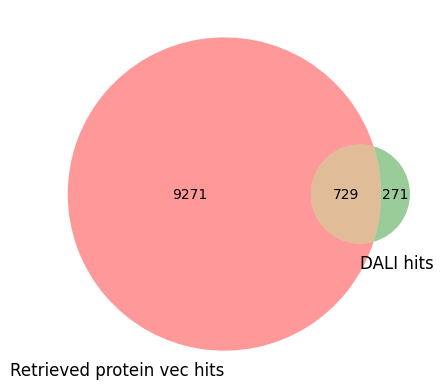

In [96]:
# look at top 1000 DALI hits vs top 10000 retrieved protein vec hits
venn2([set(metadata_test[0:10000]), set(dali_test_sorted[0:1000]['target'])], ('Retrieved protein vec hits', 'DALI hits'))

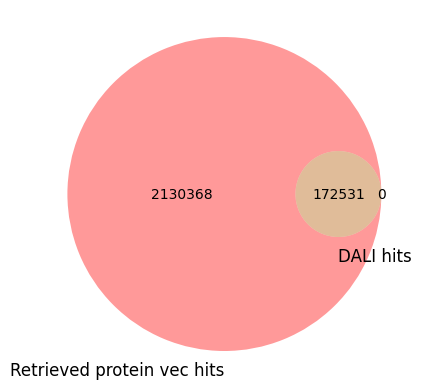

In [87]:
# make venn diagram of the intersection of the DALI results and the nearest neighbors, which would be metadata_test and dali_test['target']
venn2([set(metadata_test), set(dali_test['target'])], ('Retrieved protein vec hits', 'DALI hits'))
# set(dali_test[dali_test['Z'] > 10]['target'])


In [77]:
dali_test['Z'].describe()

count    172531.000000
mean          3.134578
std           1.322030
min           2.000000
25%           2.300000
50%           2.800000
75%           3.600000
max          41.500000
Name: Z, dtype: float64

In [98]:
# Create a dictionary where the keys are the elements of afdb_metadata and the values are their indices
afdb_metadata_dict = {value: index for index, value in enumerate(afdb_metadata)}

# Now use this dictionary to find the indices of the elements in dali_test['target']
metadata_test_target = [afdb_metadata_dict[x] for x in dali_test['target'] if x in afdb_metadata_dict]

In [102]:
lookup_dict_test = {value: index for index, value in enumerate(I[0])}

In [103]:
# dali_faiss_intersection = [lookup_dict_test[x] for x in metadata_test_target if x in lookup_dict_test]
dali_faiss_idcs = [lookup_dict_test[x] for x in metadata_test_target]

In [113]:
# KL divergence between the two distributions D[0][dali_faiss_idcs] and D[0]
from scipy.stats import entropy

# Ensure the distributions are normalized to represent probabilities
# dist1 = D[0][dali_faiss_idcs] / np.sum(D[0][dali_faiss_idcs])
# dist2 = D[0] / np.sum(D[0])

# # Calculate the KL divergence
# kl_divergence = entropy(dist1, dist2)

# Create a new array of zeros with the same shape as D[0]
full_dist1 = np.zeros_like(D[0])

# Place the values of D[0][dali_faiss_idcs] at the corresponding indices in the new array
full_dist1[dali_faiss_idcs] = D[0][dali_faiss_idcs]

# Now full_dist1 and D[0] have the same shape, and you can compute the KL divergence as before
dist1 = full_dist1 / np.sum(full_dist1)
dist2 = D[0] / np.sum(D[0])

kl_divergence = entropy(dist1, dist2)

In [115]:
print(np.mean(D[0][dali_faiss_idcs]), np.mean(D[0]))
print(np.std(D[0][dali_faiss_idcs]), np.std(D[0]))
print(np.min(D[0][dali_faiss_idcs]), np.min(D[0]))
print(np.max(D[0][dali_faiss_idcs]), np.max(D[0]))
print(np.median(D[0][dali_faiss_idcs]), np.median(D[0]))


0.9997702 0.99975544
5.3681983e-05 5.4961118e-05
0.99943256 0.9994294
0.9999858 0.9999858
0.9997734 0.9997598


Text(0.5, 1.0, 'protein-vec distance distribution of DALI hits vs all hits')

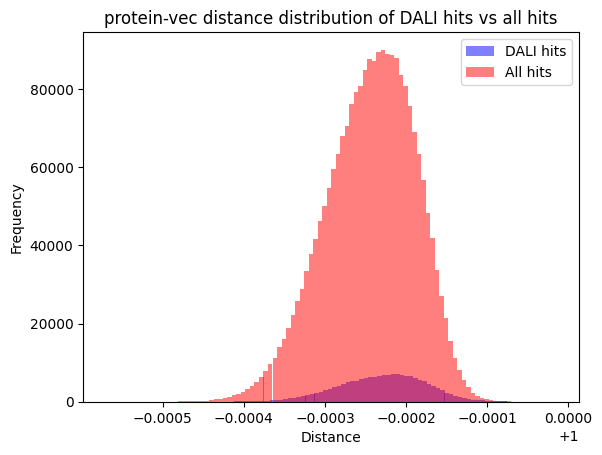

In [106]:
plt.hist(D[0][dali_faiss_idcs], bins=100, alpha=0.5, label='DALI hits', color='blue')
plt.hist(D[0], bins=100, alpha=0.5, label='All hits', color='red')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('protein-vec distance distribution of DALI hits vs all hits')

In [97]:
# index into afdb metadata with dali_test['target']
metadata_test_target = [afdb_metadata.index(x) for x in dali_test['target']]

KeyboardInterrupt: 

In [64]:
afdb_metadata.index(dali_test['target'][0])

1107878